In [4]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras import models
from keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import rgb_to_grayscale
from tensorflow import reshape
from tensorflow.image import resize_with_pad
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
import os
import numpy as np

%matplotlib inline

import sys
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Custom modules 
from modules import data, graphs, eda


plt.style.use('ggplot')

In [5]:
model = models.load_model("../../src/models/vgg16-1-dan-batch-25/")

In [82]:
model2 = models.load_model("../../src/models/2020-12-02tim-1.HDF5/")

In [17]:
image_dict = data.import_image_to_array('/../../src/data/chest_xray/', test=False, grayscale=False, shape=(224,224))

Your relative directory is good, proceeding to import files...

Loading images from train
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from test
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from val
Finished loading images from NORMAL
Finished loading images from PNEUMONIA



In [18]:
images = image_dict
X_train = np.array([i[1] for i in images['train']])  
y_train = np.array([i[2] for i in images['train']])

X_test = np.array([i[1] for i in images['test']])
y_test = np.array([i[2] for i in images['test']])

X_val = np.array([i[1] for i in images['val']])
y_val = np.array([i[2] for i in images['val']])

In [19]:
X_train[1].shape

(224, 224, 3)

In [61]:
def get_false_negatives(fit_model, X_test, y_test, threshold=0.5):
    """
    Returns a numpy array of index matched false negatives
    """
    predictions =  [1 if p > 0.5 else 0 for p in fit_model.predict(X_test)]
    comparisons = list(zip(y_test, predictions))
    return np.array([1 if (true == 1 and prediction == 0) else 0 for true, prediction in comparisons])

In [65]:
fn_array = get_false_negatives(model, X_val, y_val, threshold=0.)

In [66]:
fn_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [67]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [78]:
predictions = model.predict(X_test)

In [81]:
sum(predictions > 0.5)

array([477])

In [141]:
# Define a stacked classifer
from scipy import stats


def stacked_classifier(list_of_models,
                       X_test,
                       y_test,
                       model_input_shape=None, 
                       model_weights=None,
                       threshold=0.5,
                       soft_voting=True):
    """
    given a list of classifiers, returns a hard or soft voting array of predictions
    """
    # instantiate a prediction matrix
    
    m = len(X_test) # matrix rows
    n = len(list_of_models) # matrix columns
    
    prediction_matrix = np.ones((m,n))
    
    # update predictions matrix
    for i in range(0,n):
        print(f"Generating predictions for model {i+1}")
        model = list_of_models[i]
        p = model.predict(X_test)
        prediction_matrix[:,i] *= p.ravel()
        print(f"Finished prediction on model {i+1}")
    
    # Adjust the weights of each prediction
    if model_weights:
        print("Adjusting weights of the classifier's predictions")
        for i, weight in enumerate(model_weights):
            prediction_matrix[:,i] *= model_weights[weight]
    
    if not soft_voting:
        print("Returning hard voting predictions")
        preditions =  prediction_matrix > threshold
        return stats.mode(predictions, axis=1)

    else:
        print("Returning soft voting predictions")
        predictions = np.mean(prediction_matrix, axis=1)
        return predictions > threshold
    

In [142]:
weights = {
    "model1": 1,
    "model2": 1,
}
stacked_classifier([model, model], X_val, y_val, model_weights=weights)


Generating predictions for model 1
Finished prediction on model 1
Generating predictions for model 2
Finished prediction on model 2
Adjusting weights of the classifier's predictions
Returning soft voting predictions


array([False, False, False, False,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [277]:
def get_false_positives(predictions, y_test):
    """
    Returns a numpy array of index matched false negatives
    predictions --> binary or bool
    y_test --> binary or bool
    theshold 
    
    returns a np.array
    """
    comparisons = list(zip(y_test, predictions))
    return np.array([1 if (true == 0 and prediction == 1) else 0 for true, prediction in comparisons])


# Create a function to return a list of 10 images from the false positive class

def import_image(PATH, name, shape=(224,224)):
    """
    PATH --> str: Relative path to image directoy
    eg 'src/data/xray/train/''
    image_names --> list -> str: Names of the images to load
    
    Returns:
    List -> PIL images
    
    """
    
    # create path to file
    img_path = PATH + name
    # load file and return pil
    return image.load_img(img_path).resize(shape)



def get_image_names(image_dict, false_positives, key='test'):
    """
    image_dict -> dict
    false_postives -> array
    key -> string
    imbalanc -> bool
    """
    tuple_ = image_dict[key]
    image_names = [tup[0] for tup in tuple_]

    name_plus_flags = list(zip(image_names, false_positives))
    
    
    
    return [i for i,j in name_plus_flags if j == 1]
    

def display_bv_images(image_list, PATH, shape=(224,224)):
    
    fig = plt.figure(figsize = (12,6))
    for i, image in enumerate(image_list):  
        label = f'Image {i+1}'
        ax = fig.add_subplot(2, 3, i+1)
        
        # to plot without rescaling, remove target_size
        plt.imshow(image_list[i].resize(shape), cmap='Greys_r')
        plt.title(label)
        plt.axis('off')
    plt.show()
    

def see_false_positives(image_dict, y_hat, PATH="./src/data/x_ray/NORMAL/", shape=(100,100), key='test', num_images=2):
    """
    Image_dict: dict; str -> tuple(str, matrix, int)
    y_hat -> prediction, list->int
    PATH -> str, directory to the normal xray images
    shape -> tuple-> (int,int)
    key -> str: The set from the dictionary tha you want to visualize. eg val, train, test
    
    
    Need numpy and matplotlib. Will display 6 random images from the false positive class.
    
    """
    # get true positives
    y_true  = [i[2] for i in image_dict[key]]
    
    # get false positives
    false_p = get_false_positives(y_hat, y_true)
    
    # get names of the false positives
    image_names = get_image_names(image_dict, false_p, key=key)
    
    # select 6 random images from the false positive names
    random_images = np.random.choice(a=image_names, size=num_images, replace=False)
    # import the 6 images 
    
    image_list = [import_image(PATH, image_name, shape=shape) for image_name in random_images]
    
    # display 6 random false positives 
    display_bv_images(image_list, PATH, shape=shape)
    
    

images loaded


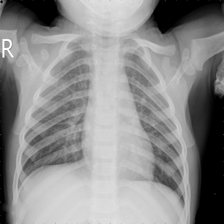

In [278]:
image_name = 'NORMAL2-IM-1430-0001.jpeg'
shape = (224,224)
import_images(PATH, image_name, shape=shape)

In [279]:
y_hat = y_hat > 0.5

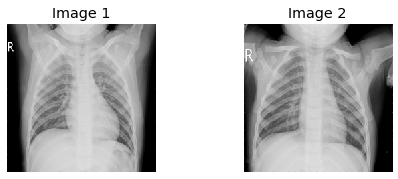

In [280]:
PATH = './../../src/data/chest_xray/val/NORMAL/'
see_false_positives(images, y_hat, PATH, key='val', shape = (224,224))